In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes, Subplot

import ccdproc
import photutils
import glob
import astropy

from astropy import units as u
from astropy import stats

from astropy.io import ascii
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy.nddata import CCDData, NDData, VarianceUncertainty
from astropy.modeling import models


#import matplotlib.pyplot.subplots as subplots

from ccdproc import ImageFileCollection, Combiner
from astropy.nddata import NDData, NDArithmeticMixin

In [2]:
wolf1_file = '/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/wolf1346_.0001.fits'
flat_list = glob.glob('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/flats/*.fits')
bias_list = glob.glob('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/bias/*.fits')

#hdulist = ccd_masked.to_hdu()

#image1 = CCDData.read(‘/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/wolf1346_.0001.fits’,unit=”electron”)
#image2 = CCDData.read(‘/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/wolf1346_.0002.fits’,unit=”electron”)
#image3 = CCDData.read(‘/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/wolf1346_.0003.fits’,unit=”electron”)
#image4 = CCDData.read(‘/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/wolf1346_m.0001.fits’,unit=”electron”)

#wolf_all = Combiner([image1, image2, image3, image4])

In [3]:
wolf1 = CCDData.read(wolf1_file, unit="adu")

print("The image has a shape [height,width] of {0}".format(wolf1.shape))
print("The image is made up of data of type {0}".format(wolf1.dtype))
print(" ")
#print(repr(wolf1.header))

The image has a shape [height,width] of (2050, 2102)
The image is made up of data of type uint16
 


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
# These are empty lists (arrays) to store the mean counts
means_bias = []

for filename in bias_list:
    # Open the FITS file
    hdu_bias = fits.open(filename)
    
    mean_counts = np.mean(hdu_bias[0].data)
    print('Bias counts (mean): {:.2f}\n'.format(mean_counts))
    means_bias.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
means_bias = np.array(means_bias)
meanest_bias = np.mean(means_bias)
print('Master bias count: {:.2f}\n'.format(meanest_bias))
print(means_bias)

Bias counts (mean): 351.58

Bias counts (mean): 351.69

Bias counts (mean): 351.68

Bias counts (mean): 351.40

Bias counts (mean): 351.65

Bias counts (mean): 351.68

Bias counts (mean): 351.36

Bias counts (mean): 351.74

Bias counts (mean): 351.71

Bias counts (mean): 351.70

Bias counts (mean): 351.50

Master bias count: 351.61

[351.57523125 351.69432573 351.67511638 351.40129447 351.65315008
 351.67762201 351.35681395 351.73834583 351.71165371 351.7035432
 351.49990439]


In [5]:
icl_bias = ImageFileCollection('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/bias/', keywords='*')

In [6]:
bias_data = []
for hdu, fname in icl_bias.hdus(imagetyp='bias', return_fname=True):
    meta = hdu.header
    meta['filename'] = fname
    bias_data.append(ccdproc.CCDData(data=hdu.data, meta=meta, unit="adu"))


#bias_data = [CCDData.read(filename, unit="adu") for filename in bias_list]

In [7]:
c_bias = Combiner(bias_data)
master_bias = c_bias.average_combine()

In [8]:
poly_model = models.Polynomial1D(1)

oscan_subtracted = ccdproc.subtract_overscan(master_bias,overscan=master_bias[:, 200:],overscan_axis=1,model=poly_model)

In [18]:
            #this cell doesnt work... must do it the hard way

#flat_data = [CCDData.read(filename, unit="adu") for filename in flat_list]
#icl_flats = ImageFileCollection('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/flats/', keywords='*')

In [9]:
# These are empty lists (arrays) to store the exposure times and mean counts
exp_times = []
fil = []
means = []
flat_data = []

for filename in flat_list:
    # Open the FITS file
    #betterlist = find_all_wcs(header, relax=True, keysel=None, fix=True, translate_units='', _do_set=True)
    hdu = fits.open(filename)
    
    mean_counts = np.mean(hdu[0].data)
    means.append(mean_counts)
    
    exptime = hdu[0].header['exptime']
    exp_times.append(exptime)
    
    filters = hdu[0].header['filter']
    fil.append(filters)
    
    print('Used the {0:} filter, for {1:} sec'.format(filters,exptime))
    
    meta = hdu[0].header
    flat_data.append(ccdproc.CCDData(data=hdu[0].data, meta=meta, unit="adu"))

# Convert to Numpy arrays so they can be sorted
exp_times = np.array(exp_times)
fil = np.array(fil)
means = np.array(means)
#flat_data = np.array(flat_data)

#means = means[time_sort]

Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 2.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 10.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 1.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the Wash M filter, for 3.0 sec
Used the J-C Rc filter, for 4.0 sec
Used the J-C Rc filter, for

In [10]:
            #this cell would work if we were given flats that had correct coordinates

c_flat = Combiner(flat_data)
master_flat = c_flat.average_combine()


noise = add(master_bias, operand2=oscan_subtracted, **kwargs)
nonbias_wolf=subtract(wolf1, operand2=noise, **kwargs)


clean_wolf = ccdproc.flat_correct(nonbias_wolf, master_flat)

MemoryError: 

Text(99.125, 0.5, 'Declination (J2000)')

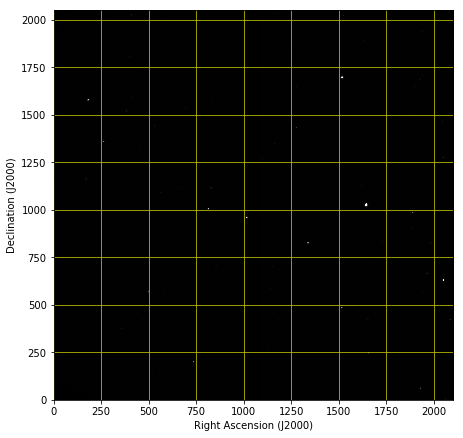

In [11]:
fig = plt.figure()

ax1 = fig.add_subplot(121)

fig.set_size_inches(14,6)
fig.tight_layout()

ax1.imshow(wolf1, origin='lower', cmap=plt.cm.gray)
ax1.grid(color='y', ls='-')
ax1.set_xlabel('Right Ascension (J2000)')
ax1.set_ylabel('Declination (J2000)')

In [ ]:
#this cell represents the hrs i spent trying to fix the header keyword that made icl unable to parse 
        #through the fits cards CD_1 and CD_2

    
#hdu = wolf1.to_hdu()
#hdu.verify('fix')

#keys = ['exptime','filter','imagetyp']
#ic1_flats = ImageFileCollection('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/flats/', keywords=keys)
#icl_wolf = uImageFileCollection('/home/andibergeson/Desktop/Astro480/DataLab/Wolf1346/data/', keywords=keys)

#ic1.summary.colnames